In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from glob import glob

glob('*')

['fashion-mnist_train.csv',
 'untitled1.py',
 'untitled3.py',
 'fashion-mnist_test.csv',
 'f_mnist.ipynb',
 'untitled.py',
 'models.ipynb',
 'untitled2.py',
 'data',
 'cifar10.ipynb']

In [3]:
train_df=pd.read_csv('fashion-mnist_train.csv')
test_df=pd.read_csv('fashion-mnist_test.csv')

In [4]:
classes={
    0 : 'T-shirt/top',
    1 : 'Trouser',
    2 : 'Pullover',
    3 : 'Dress',
    4 : 'Coat',
    5 : 'Sandal',
    6 : 'Shirt',
    7 : 'Sneaker',
    8 : 'Bag',
    9 : 'Ankle boot',

}

In [5]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
from torch.utils.data import random_split

In [6]:
def imshow(image):
    image=image.numpy()
    plt.imshow(np.transpose(image,(1,2,0)),cmap='binary')
    plt.show()

In [7]:
class AddGaussianNoise():
    def __init__(self,mean=0.,std=0.):
        self.mean=mean
        self.std=std
        
    
    def __call__(self,tensor):
        return tensor+torch.rand(tensor.shape)*self.std+self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [8]:
class Cdataset(Dataset):
    def __init__(self,dataframe,transform=None):
        self.dataframe=dataframe
        self.transform=transform
    
    def __len__(self):
        return self.dataframe.shape[0]
        
    def __getitem__(self,idx):
        image=self.dataframe.iloc[idx,1:]
        image=image.values.reshape(28,28,1)/255.0
        image=transforms.ToTensor()(image)
        image=image.to(torch.float32)
        label=self.dataframe.iloc[idx,0]
        if self.transform:
            image=self.transform(image)
        return image,label
    

transform=transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    AddGaussianNoise(),
])


df=Cdataset(train_df,transform)
test=Cdataset(test_df)

In [9]:
train_df.iloc[0,0]

2

In [10]:
train,val=random_split(df,[0.85,0.15])

In [11]:
trainloader=DataLoader(train,batch_size=512,shuffle=True,num_workers=14)
valloader=DataLoader(val,batch_size=800,shuffle=False,num_workers=14)
testloader=DataLoader(test,batch_size=800,shuffle=False)

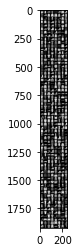

In [12]:
image,label=next(iter(trainloader))
imshow(make_grid(image))

In [13]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Conv2d(1,96,7,padding=1)
        self.pool=nn.MaxPool2d(2,2)
        self.batch1=nn.BatchNorm2d(96)
        
        self.conv2=nn.Conv2d(96,80,5,padding=1)
        self.batch2=nn.BatchNorm2d(80)

        self.conv3=nn.Conv2d(80,96,5,padding=1)
        self.batch3=nn.BatchNorm2d(96)

        self.conv4=nn.Conv2d(96,64,3,padding=1)
        self.batch4=nn.BatchNorm2d(64)

        self.fc1=nn.Linear(576,512)
        self.batch5=nn.BatchNorm1d(512)
        self.drop=nn.Dropout(0.5)
        self.fc2=nn.Linear(512,256)
        self.batch6=nn.BatchNorm1d(256)
        self.drop1=nn.Dropout(0.5)
        self.fc3=nn.Linear(256,10)
        
    def forward(self,x):
        x=self.pool(F.relu(self.batch1(self.conv1(x))))
        x=self.pool(F.relu(self.batch2(self.conv2(x))))
        x=self.batch3(self.conv3(x))
        x=self.batch4(self.conv4(x))
        x=torch.flatten(x,1)
        x=F.relu(self.batch5(self.fc1(x)))
        x=self.drop(x)
        x=F.relu(self.batch6(self.fc2(x)))
        x=self.drop1(x)
        x=self.fc3(x)
        return x

n=Net()

In [14]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(n.parameters(),lr=0.01)

In [15]:
import time

In [16]:
def train(epochs):
    for epoch in range(epochs):
        st=time.monotonic()
        total=0
        correct=0
        running_loss=0

        for data in trainloader:
            inputs,labels=data
            optimizer.zero_grad()
            output=n(inputs)
            loss=criterion(output,labels)
            loss.backward()
            optimizer.step()

            total+=labels.size(0)
            correct+=(torch.max(output,1)[1]==labels).sum().item()
            running_loss+=loss.item()

        val_correct=0
        val_total=0
        with torch.no_grad():
            for data in valloader:
                images,labels=data
                outputs=n(images)
                _,predicted=torch.max(outputs.data,1)
                val_total+=labels.size(0)
                val_correct+=(predicted==labels).sum().item()


        en=time.monotonic()
        print(f'[{en-st :.1f}s] [{epoch + 1}/{epochs}] loss: {running_loss / len(trainloader):.3f}, train acc : { (correct/total)*100 :.3f}%, val_acc : {(val_correct/val_total)*100 :.3f}% ')


In [17]:
lr_list=[0.01,0.003]

for lr in lr_list:
    optimizer.lr=lr
    print('lr : '+ str(lr))
    match lr:
        case 0.01:
            train(30)
        case 0.003:
            train(15)
        

lr : 0.01
[39.2s] [1/30] loss: 0.725, train acc : 72.492%, val_acc : 81.889% 
[39.6s] [2/30] loss: 0.429, train acc : 84.408%, val_acc : 86.322% 
[39.1s] [3/30] loss: 0.350, train acc : 87.588%, val_acc : 87.000% 
[39.5s] [4/30] loss: 0.315, train acc : 88.827%, val_acc : 88.456% 
[39.6s] [5/30] loss: 0.284, train acc : 89.992%, val_acc : 89.356% 
[39.5s] [6/30] loss: 0.261, train acc : 90.737%, val_acc : 89.656% 
[39.3s] [7/30] loss: 0.240, train acc : 91.478%, val_acc : 90.078% 
[39.4s] [8/30] loss: 0.225, train acc : 92.025%, val_acc : 90.000% 
[39.3s] [9/30] loss: 0.216, train acc : 92.276%, val_acc : 90.544% 
[39.0s] [10/30] loss: 0.206, train acc : 92.645%, val_acc : 90.600% 
[39.0s] [11/30] loss: 0.192, train acc : 93.088%, val_acc : 90.233% 
[39.1s] [12/30] loss: 0.179, train acc : 93.529%, val_acc : 90.878% 
[39.2s] [13/30] loss: 0.170, train acc : 93.971%, val_acc : 90.522% 
[39.1s] [14/30] loss: 0.157, train acc : 94.400%, val_acc : 90.478% 
[39.3s] [15/30] loss: 0.153, trai

In [18]:
from torchvision import models

t_model=models.mobilenet_v3_large(pretrained=True)
t_model.features[0][0]=nn.Conv2d(1,16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
t_model.classifier=nn.Sequential(nn.Linear(t_model.classifier[0].in_features,256),
                                 nn.BatchNorm1d(256),
                                 nn.Dropout(0.4),
                                 nn.Linear(256,10))

/home/kali/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kali/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
optimizer1=optim.Adam(t_model.parameters(),lr=0.01)

In [20]:
def t_train(epochs):
    for epoch in range(epochs):
        st=time.monotonic()
        total=0
        correct=0
        running_loss=0

        for data in trainloader:
            inputs,labels=data
            optimizer1.zero_grad()
            output=t_model(inputs)
            loss=criterion(output,labels)
            loss.backward()
            optimizer1.step()

            total+=labels.size(0)
            correct+=(torch.max(output,1)[1]==labels).sum().item()
            running_loss+=loss.item()

        val_correct=0
        val_total=0
        with torch.no_grad():
            for data in valloader:
                images,labels=data
                outputs=t_model(images)
                _,predicted=torch.max(outputs.data,1)
                val_total+=labels.size(0)
                val_correct+=(predicted==labels).sum().item()


        en=time.monotonic()
        print(f'[{en-st :.1f}s] [{epoch + 1}/{epochs}] loss: {running_loss / len(trainloader):.3f}, train acc : { (correct/total)*100 :.3f}%, val_acc : {(val_correct/val_total)*100 :.3f}% ')


In [21]:
lr_list=[0.01,0.001]

for lr in lr_list:
    optimizer1.lr=lr
    print('lr : '+ str(lr))
    match lr:
        case 0.01:
            t_train(40)
        case 0.001:
            t_train(15)

lr : 0.01
[83.8s] [1/40] loss: 0.627, train acc : 77.061%, val_acc : 84.389% 
[82.4s] [2/40] loss: 0.368, train acc : 86.680%, val_acc : 86.222% 
[83.3s] [3/40] loss: 0.313, train acc : 88.643%, val_acc : 88.667% 
[83.4s] [4/40] loss: 0.281, train acc : 89.692%, val_acc : 89.433% 
[85.1s] [5/40] loss: 0.266, train acc : 90.225%, val_acc : 89.144% 
[79.2s] [6/40] loss: 0.248, train acc : 91.022%, val_acc : 90.211% 
[84.5s] [7/40] loss: 0.237, train acc : 91.422%, val_acc : 90.322% 
[85.7s] [8/40] loss: 0.231, train acc : 91.580%, val_acc : 90.678% 
[85.3s] [9/40] loss: 0.217, train acc : 92.037%, val_acc : 90.400% 
[80.3s] [10/40] loss: 0.214, train acc : 92.190%, val_acc : 90.889% 
[77.4s] [11/40] loss: 0.200, train acc : 92.724%, val_acc : 90.989% 
[80.8s] [12/40] loss: 0.195, train acc : 92.845%, val_acc : 90.667% 
[77.4s] [13/40] loss: 0.186, train acc : 93.198%, val_acc : 90.844% 
[77.4s] [14/40] loss: 0.184, train acc : 93.212%, val_acc : 91.178% 
[95.4s] [15/40] loss: 0.174, trai

In [22]:
def test_n():
    st=time.monotonic()

    test_correct=0
    test_total=0
    
    with torch.no_grad():
        for data in testloader:
            images,labels=data
            outputs=n(images)
            _,predicted=torch.max(outputs.data,1)
            test_total+=labels.size(0)
            test_correct+=(predicted==labels).sum().item()
    
    en=time.monotonic()

    print(f'[{en-st :.1f}s] test acc : {(test_correct/test_total)*100 :.3f}%')

def test_t():
    st=time.monotonic()

    test_correct=0
    test_total=0
    
    with torch.no_grad():
        for data in testloader:
            images,labels=data
            outputs=t_model(images)
            _,predicted=torch.max(outputs.data,1)
            test_total+=labels.size(0)
            test_correct+=(predicted==labels).sum().item()
    
    en=time.monotonic()

    print(f'[{en-st :.1f}s]   test acc : {(test_correct/test_total)*100 :.3f}%')
        

In [23]:
test_n()

[3.2s] test acc : 91.800%


In [24]:
test_t()

[5.2s]   test acc : 91.770%
